In [1]:
import numpy as np
import pandas
from fontTools.varLib.interpolatableHelpers import rot_list
import matplotlib.pyplot as plt
import task
import networkx as nx
import task_seqs

In [7]:
mycombo = task.Sequence()
mycombo.from_term_list(['GM Scoot','Gainer','Wrap/GM Full','Double Cork'])
print(mycombo.name)
print(mycombo.segms)
print(mycombo.params)

GM Scoot - Gainer - Wrap/GM Full - Double Cork
[['F2'], ['F1'], ['F2'], ['F1'], ['F1']]
{'Dphis': [0, 1, 1, 1, 1], 'Dpsis': [0, 0, 0, 1, 2], 'omega_phis': [], 'omega_psis': []}


In [3]:
#node_list_std = ['complete','hyper','mega','semi','backside','frontside','H1','H2','hook','round','outside','inside','dleg']
D_ambi = {('orthodox','LF'):'F1',
          ('orthodox','RF'):'F2',
          ('unorthodox','LF'):'F2',
          ('unorthodox','RF'):'F1'}
D_ambi2 = {('orthodox','F1'):'LF',
          ('orthodox','F2'):'RF',
          ('unorthodox','F1'):'RF',
          ('unorthodox','F2'):'LF'}
D_terms = {(0,0,'F1'):'C',
           (0,0,'F2'):'H',
           (0,0.5,'F1'):'M',
           (0,0.5,'F2'):'S',
           (0.5,0,'F2'):'RK',
           (0.5,0.5,'F1'):'HK',
           (0.5,0.25,'F1'):'OK',
           (0.5,0.25,'F2'):'IK',}
           #(0.5,0.25,'BF'):'DL'}
#put these into tables/matrices...

def digraph_from_task_seq(segms,rotdiffs,tricking_side='orthodox'):
    DG = nx.DiGraph(tricking_side=tricking_side)
    phi_tot,psi_tot = 0,0
    edge_labels,pos_dict = {},{}
    for i in range(0,len(segms)):
        segm_ambi = D_ambi[tricking_side,segms[i]]
        tsk = task.Task(name=D_terms[(phi_tot % 1,psi_tot % 1,segm_ambi)],segms=segm_ambi)
        DG.add_nodes_from([(i,tsk.get_dict())])
        pos_dict.update({i:np.array([phi_tot,psi_tot])})
        DG.nodes[i].update({'phitot':phi_tot,'psitot':psi_tot})
        if i!=len(segms)-1:
            Dphi,Dpsi = rotdiffs[i]
            tsk.add_rot(Dphi,Dpsi)
            DG.add_edges_from([(i,i+1,{'phidiff':Dphi,'psidiff':Dpsi})])
            edge_labels.update({(i,i+1):(Dphi,Dpsi)})
            phi_tot += Dphi
            psi_tot += Dpsi
    return DG,pos_dict,edge_labels

[(1.0, 1.5), (1.0, 1.5), (1.0, 1.5), (1.0, 0.5), (1.0, 1.0)]


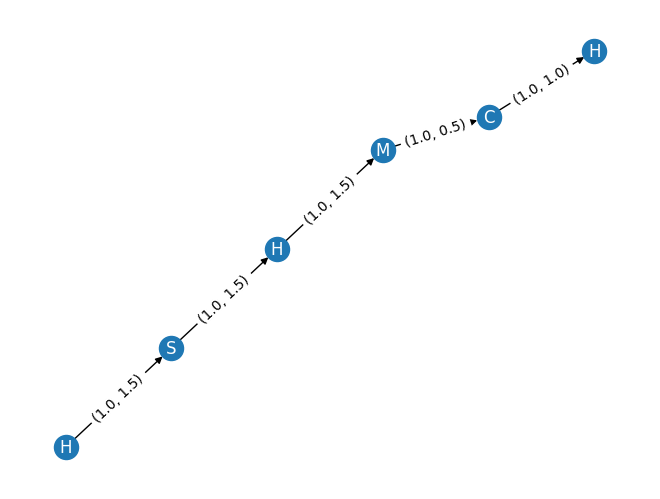

In [4]:
#specifying the task sequence
tricking_side = 'orthodox'
combo_length = 5
segms = np.random.choice(np.array(['LF','RF']),size=combo_length+1)
phidiffs = [1.0]*combo_length
psidiffs = np.random.choice(np.array([0,0.5,1,1.5]),size=combo_length)
rotdiffs = [(float(phidiff),float(psidiff)) for phidiff,psidiff in zip(phidiffs,psidiffs)]
print(rotdiffs)

#generating graph
DG,pos_dict,edge_labels = digraph_from_task_seq(segms,rotdiffs,tricking_side)
nx.draw(DG, pos_dict)
nx.draw_networkx_labels(DG, pos_dict, labels = nx.get_node_attributes(DG,'abbrev_name'),font_color='white')
nx.draw_networkx_edge_labels(DG, pos_dict, edge_labels = edge_labels)
plt.show()

In [5]:
def from_prim_to_term(DG):
    DG = DG.copy()
    tricklist = []
    for i in range(len(DG.nodes)-1):
        start_foot = DG.nodes[i]['segms']
        end_foot = DG.nodes[i+1]['segms']
        Dphi = DG.edges[i,i+1]['phidiff']
        Dpsi = DG.edges[i,i+1]['psidiff']
        phi_tot = DG.nodes[i]['phitot']
        psi_tot = DG.nodes[i]['psitot']
        if psi_tot%1 == 0:
            start_rot = 'BSide'
        elif psi_tot%1 == 0.5:
            start_rot = 'FSide'
        trick_name = [value for key, value in task_seqs.task_seq_by_rot.items() if key == (start_rot,start_foot,end_foot,Dphi,Dpsi)][0]
        DG.edges[i,i+1].update({'term':trick_name})
        tricklist.append(trick_name)
    return DG,tricklist

def from_term_to_prim(tricklist,tricking_side='orthodox'):
    #1 get psi_start from first trick to create node 0
    #2 calculate psi_tot after the first trick (psi_tot = psi_0 + Dpsi) and save it
    #3 compare start_psi from second trick to psi_tot % 1. If matches, create node 1 and edge (0,1), if not break.
    #4 calculate psi_tot after the second trick (psi_tot += Dpsi) and save it
    #5 compare start_psi from third trick to psi_tot % 1. If matches, create node 2 and edge (1,2), if not break.
    #...
    #6 after the iteration, create end node using the end_psi of the last trick
    DG = nx.DiGraph(tricking_side=tricking_side)
    segms = []
    rotdiffs = []
    for i in range(len(tricklist)):
        trick = tricklist[i]
        start_rot,start_foot,end_foot,Dphi,Dpsi = task_seqs.task_seq_by_rot_inv[trick]
        if i==0:
            if start_rot == 'BSide':
                psi_tot = 0
            elif start_rot == 'FSide':
                psi_tot = 0.5
            DG.add_node(0,name=D_terms[(0,psi_tot%1,start_foot)],segms=start_foot,psitot=psi_tot)
        elif i>0:
            if (start_rot == 'BSide' and psi_tot%1 == 0) or (start_rot == 'FSide' and psi_tot%1 == 0.5):
                DG.add_node(i,name=D_terms[(0,psi_tot%1,start_foot)],segms=start_foot,psitot=psi_tot)
                DG.add_edge(i-1,i,term=trick,phidiff=Dphi,psidiff=Dpsi)
            else:
                print('Comboing ',tricklist[i-1],' to ',tricklist[i],' not possible.')
                break
        psi_tot += Dpsi
        segms.append(D_ambi2[(tricking_side,start_foot)])
        rotdiffs.append((1,Dpsi))
    DG.add_node(i+1,name=D_terms[(0,psi_tot%1,end_foot)],segms=end_foot,psitot=psi_tot)
    segms.append(D_ambi2[(tricking_side,end_foot)])
    return DG,segms,rotdiffs

DG_transl,tricklist = from_prim_to_term(DG)
print(tricklist)
DG_back,segms,rotdiffs = from_term_to_prim(tricklist)
print(segms)
print(rotdiffs)

AttributeError: module 'task_seqs' has no attribute 'task_seq_by_rot'

In [5]:
import pandas as pd

tricks_dict = task_seqs.task_seq_by_stance(inverse=True)
df = pd.DataFrame.from_dict(tricks_dict,orient='index',columns=['Takeoff Stance','Landing Stance','Flip Rotation','Twist Rotation'])
df

Takeoff Stance Landing Stance  Flip Rotation  \
Gainer Switch                            C              C              1   
Gainer Mega/Scissor                      C              M              1   
Cork                                     C              C              1   
Cork Mega                                C              M              1   
Double Cork                              C              C              1   
Triple Cork                              C              C              1   
Quad Cork                                C              C              1   
Gainer                                   C              H              1   
Gainer Semi                              C              S              1   
Cork Hyper                               C              H              1   
Cork Semi                                C              S              1   
GM Scoot                                 H              C              1   
GM Swipe Mega                            H              M              1   
GM/Wrap Full                             H              C              1   
GM/Wrap Full Mega                        H              M              1   
GM Swipe                                 H              H              1   
GM Swipe Semi                            H              S              1   
GM/Wrap Full Hyper                       H              H              1   
GM/Wrap Full Semi                        H              S              1   
Aerial Mega/Scissor                      M              M              1   
Btwist                                   M              C              1   
Btwist Mega                              M              M              1   
Double Btwist                            M              C              1   
Webster (Mega-Semi)                      M              S              1   
Aerial                                   M              H              1   
Aerial Semi                              M              S              1   
Btwist Hyper                             M              H              1   
Webster (Semi-Mega)                      S              M              1   
Raiz                                     S              C              1   
Raiz Mega/Scissor                        S              M              1   
Front Cork Mega                          S              C              1   
Webster (Semi-Semi)                      S              S              1   
Sideswipe                                S              H              1   
Sideswipe Semi / Front Cork              S              S              1   
Front Cork Hyper                         S              H              1   

                             Twist Rotation  
Gainer Switch                           0.0  
Gainer Mega/Scissor                     0.5  
Cork                                    1.0  
Cork Mega                               1.5  
Double Cork                             2.0  
Triple Cork                             3.0  
Quad Cork                               4.0  
Gainer                                  0.0  
Gainer Semi                             0.5  
Cork Hyper                              1.0  
Cork Semi                               1.5  
GM Scoot                                0.0  
GM Swipe Mega                           0.5  
GM/Wrap Full                            1.0  
GM/Wrap Full Mega                       1.5  
GM Swipe                                0.0  
GM Swipe Semi                           0.5  
GM/Wrap Full Hyper                      1.0  
GM/Wrap Full Semi                       1.5  
Aerial Mega/Scissor                     0.0  
Btwist                                  0.5  
Btwist Mega                             1.0  
Double Btwist                           1.5  
Webster (Mega-Semi)                     0.0  
Aerial                                  0.5  
Aerial Semi                             1.0  
Btwist Hyper                            1.5  
Web